In [52]:
import pandas as pd
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from statsforecast import StatsForecast

from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from statsmodels.tsa.arima_model import ARIMA
from statsforecast.models import AutoARIMA

In [53]:
path = "../data/parquet/dataSetFinalTratadoTop5Diseases.parquet"
df = pd.read_parquet(path)

In [54]:
df_nordeste = df[df['Regiao'] == 'NORDESTE']

In [55]:
df_regioes = df[['Data de Diagnostico', 'Regiao', 'categoria_doenca']]
df_regioes['y'] = 1

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12836\899817195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regioes['y'] = 1


In [56]:
df_regioes.dropna(inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12836\2300192166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regioes.dropna(inplace=True)


In [57]:
df_regioes['year_month'] = df_regioes['Data de Diagnostico'].dt.to_period('M')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12836\2337041449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regioes['year_month'] = df_regioes['Data de Diagnostico'].dt.to_period('M')


In [58]:
df_grouped = df_regioes.groupby(['year_month', 'Regiao', 'categoria_doenca'])['y'].sum().reset_index()

In [59]:
df_nordeste = df_grouped[df_grouped['Regiao'] == 'NORDESTE'].drop('categoria_doenca', axis=1).groupby('year_month')['y'].sum().reset_index()
df_norte = df_grouped[df_grouped['Regiao'] == 'NORTE'].drop('categoria_doenca', axis=1).groupby('year_month')['y'].sum().reset_index()

In [60]:
def verificar_periodo_completo(dataframe, coluna):
    data_mais_antiga = dataframe[coluna].min()
    data_mais_recente = dataframe[coluna].max()
    
    intervalo_completo = pd.period_range(start=data_mais_antiga, end=data_mais_recente, freq='M')
    
    todas_datas_presentes = all(data in dataframe[coluna].values for data in intervalo_completo)

    return data_mais_antiga, data_mais_recente, todas_datas_presentes

In [61]:
dfs = [df_nordeste, df_norte]

for df in dfs:
    data_mais_antiga, data_mais_recente, todas_datas_presentes = verificar_periodo_completo(df, 'year_month')
    print(f"Data mais antiga: {data_mais_antiga}, Data mais recente: {data_mais_recente}, Todas as datas presentes: {todas_datas_presentes}")

Data mais antiga: 1990-01, Data mais recente: 2018-12, Todas as datas presentes: True
Data mais antiga: 1996-01, Data mais recente: 2019-12, Todas as datas presentes: True


In [62]:
def recortar_dataframe(dataframe, coluna, data_inicio, data_fim):
    data_inicio = pd.Period(data_inicio, freq='M')
    data_fim = pd.Period(data_fim, freq='M')
    
    dataframe_recortado = dataframe[(dataframe[coluna] >= data_inicio) & (dataframe[coluna] <= data_fim)]
    
    return dataframe_recortado

In [63]:
df_nordeste = recortar_dataframe(df_nordeste, 'year_month', '1996-01', '2018-12')
df_norte = recortar_dataframe(df_norte, 'year_month', '1996-01', '2018-12')

In [64]:
df_norte['unique_id'] = 'NORTE'
df_nordeste['unique_id'] = 'NORDESTE'

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12836\3887296773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norte['unique_id'] = 'NORTE'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12836\3887296773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nordeste['unique_id'] = 'NORDESTE'


In [65]:
def concatenar_datasets(*dataframes):
    dataframe_concatenado = pd.concat(dataframes, ignore_index=True)
    return dataframe_concatenado

serie_regiao = concatenar_datasets(df_nordeste, df_norte)

In [66]:
serie_regiao.rename(columns={'year_month': 'ds', 'categoria_doenca': 'unique_id'}, inplace=True)

In [67]:
serie_regiao['ds'] = serie_regiao['ds'].apply(lambda x: x.to_timestamp())

In [68]:
teste_serie_regiao = serie_regiao.groupby('unique_id').tail(12)
train_serie_regiao = serie_regiao.drop(teste_serie_regiao.index, axis = 0)

In [69]:
models = [AutoARIMA(season_length = 12)]

In [70]:
sf = StatsForecast(
    df=train_serie_regiao,
    models=models,
    freq='M'
)

prev_test = sf.forecast(12, fitted=True)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:362: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.

In [71]:
prev_train = sf.forecast_fitted_values()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [72]:
prev_test = prev_test.reset_index()
prev_train = prev_train.reset_index()

In [73]:
def plot_forecasts_with_ARIMA(train, test, prev_train, prev_test):
    unique_ids = train['unique_id'].unique()
    
    for uid in unique_ids:
        plt.figure(figsize=(12, 6))
        
        train_series = train[train['unique_id'] == uid]
        plt.plot(train_series['ds'], train_series['y'], label='Treino')
        
        test_series = test[test['unique_id'] == uid]
        plt.plot(test_series['ds'], test_series['y'], label='Teste')
        
        fitted_series = prev_train[prev_train['unique_id'] == uid]
        plt.plot(fitted_series['ds'], fitted_series['AutoARIMA'], label='Previsão em treino')
        
        forecast_series = prev_test[prev_test['unique_id'] == uid]
        plt.plot(forecast_series['ds'], forecast_series['AutoARIMA'], label='Previsão em teste')
        
        plt.title(f'Série Temporais para {uid}')
        plt.xlabel('Data')
        plt.ylabel('Valores')
        plt.legend()
        plt.show()

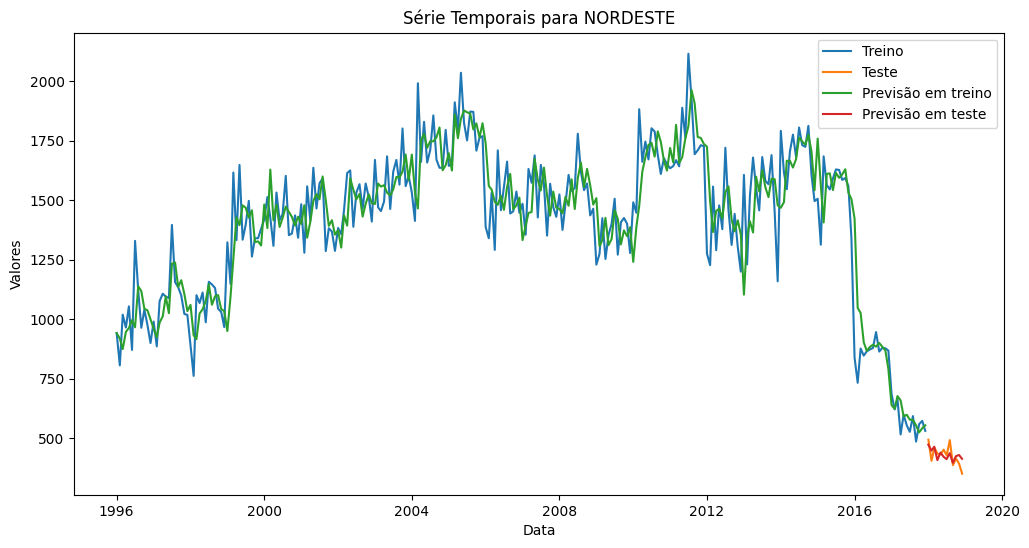

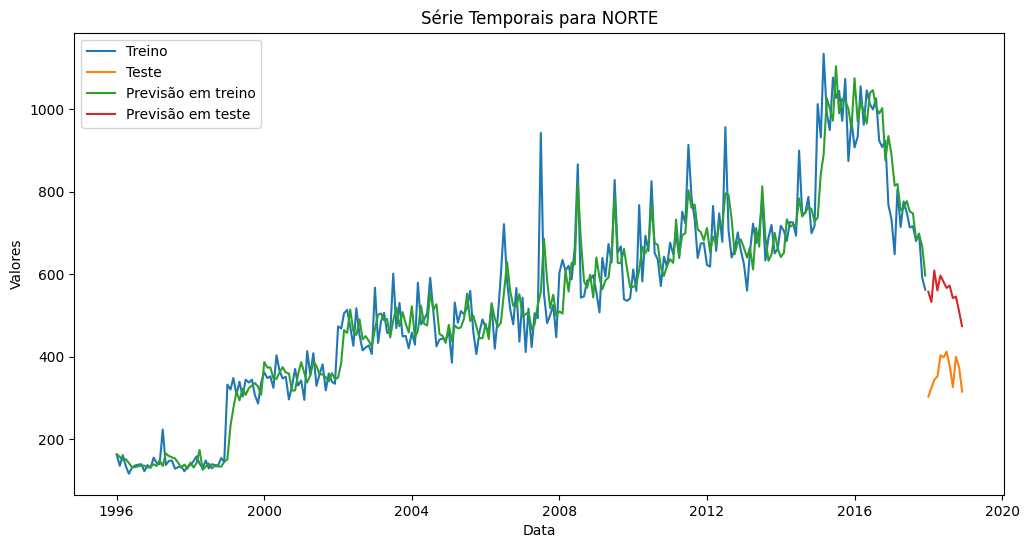

In [74]:
plot_forecasts_with_ARIMA(train_serie_regiao, teste_serie_regiao, prev_train, prev_test)

In [75]:
teste_serie_regiao

,ds,y,unique_id
264,2018-01-01,494,NORDESTE
265,2018-02-01,405,NORDESTE
266,2018-03-01,461,NORDESTE
267,2018-04-01,435,NORDESTE
268,2018-05-01,432,NORDESTE
269,2018-06-01,452,NORDESTE
270,2018-07-01,428,NORDESTE
271,2018-08-01,492,NORDESTE
272,2018-09-01,387,NORDESTE
273,2018-10-01,415,NORDESTE


In [76]:
train_serie_regiao

,ds,y,unique_id
0,1996-01-01,942,NORDESTE
1,1996-02-01,806,NORDESTE
2,1996-03-01,1019,NORDESTE
3,1996-04-01,965,NORDESTE
4,1996-05-01,1054,NORDESTE
...,...,...,...
535,2017-08-01,716,NORTE
536,2017-09-01,680,NORTE
537,2017-10-01,698,NORTE
538,2017-11-01,591,NORTE


In [77]:
prev_test

,unique_id,ds,AutoARIMA
0,NORDESTE,2017-12-31,473.217987
1,NORDESTE,2018-01-31,448.060181
2,NORDESTE,2018-02-28,464.450867
3,NORDESTE,2018-03-31,408.036346
4,NORDESTE,2018-04-30,439.674225
5,NORDESTE,2018-05-31,422.521149
6,NORDESTE,2018-06-30,412.229309
7,NORDESTE,2018-07-31,437.387146
8,NORDESTE,2018-08-31,396.600983
9,NORDESTE,2018-09-30,424.427063


In [78]:
prev_train

,unique_id,ds,y,AutoARIMA
0,NORDESTE,1996-01-01,942.0,941.057983
1,NORDESTE,1996-02-01,806.0,919.223450
2,NORDESTE,1996-03-01,1019.0,874.464661
3,NORDESTE,1996-04-01,965.0,946.711914
4,NORDESTE,1996-05-01,1054.0,963.035278
...,...,...,...,...
523,NORTE,2017-08-01,716.0,746.833313
524,NORTE,2017-09-01,680.0,684.546570
525,NORTE,2017-10-01,698.0,694.892517
526,NORTE,2017-11-01,591.0,667.164734


In [79]:
nordeste_train = prev_train[prev_train['unique_id'] == 'NORDESTE']
norte_train = prev_train[prev_train['unique_id'] == 'NORTE']

In [80]:
nordeste_test = prev_test[prev_test['unique_id'] == 'NORDESTE'].reset_index(drop=True)
norte_test = prev_test[prev_test['unique_id'] == 'NORTE'].reset_index(drop=True)

In [81]:
df_train_ajustado_nordeste = abs(nordeste_train['AutoARIMA'] - nordeste_train['y'])
df_train_ajustado_norte = abs(norte_train['AutoARIMA'] - norte_train['y'])

In [82]:
df_train_ajustado_nordeste

0        0.942017
1      113.223450
2      144.535339
3       18.288086
4       90.964722
          ...    
259     15.919495
260     68.056458
261     34.420715
262     31.001526
263     23.218872
Length: 264, dtype: float32

In [83]:
teste_serie_regiao_nordeste = teste_serie_regiao[teste_serie_regiao['unique_id'] == 'NORDESTE'].reset_index(drop=True)
teste_serie_regiao_norte = teste_serie_regiao[teste_serie_regiao['unique_id'] == 'NORTE'].reset_index(drop=True)

In [84]:
df_test_ajustado_nordeste = abs(nordeste_test['AutoARIMA'] - teste_serie_regiao_nordeste['y'])
df_test_ajustado_norte = abs(norte_test['AutoARIMA'] - teste_serie_regiao_norte['y'])

In [85]:
df_train_ajustado_nordeste = pd.DataFrame({
    'ds': nordeste_train['ds'],
    'residuals': df_train_ajustado_nordeste
})

df_train_ajustado_norte = pd.DataFrame({
    'ds': norte_train['ds'],
    'residuals': df_train_ajustado_norte
})

df_test_ajustado_nordeste = pd.DataFrame({
    'ds': teste_serie_regiao_nordeste['ds'],
    'residuals': df_test_ajustado_nordeste
})

df_test_ajustado_norte = pd.DataFrame({
    'ds': teste_serie_regiao_norte['ds'],
    'residuals': df_test_ajustado_norte
})

In [86]:
df_train_ajustado_nordeste

,ds,residuals
0,1996-01-01,0.942017
1,1996-02-01,113.223450
2,1996-03-01,144.535339
3,1996-04-01,18.288086
4,1996-05-01,90.964722
...,...,...
259,2017-08-01,15.919495
260,2017-09-01,68.056458
261,2017-10-01,34.420715
262,2017-11-01,31.001526


In [87]:
df_train_ajustado_norte

,ds,residuals
264,1996-01-01,0.162994
265,1996-02-01,21.841217
266,1996-03-01,12.151901
267,1996-04-01,17.392242
268,1996-05-01,25.566071
...,...,...
523,2017-08-01,30.833313
524,2017-09-01,4.546570
525,2017-10-01,3.107483
526,2017-11-01,76.164734


In [88]:
df_test_ajustado_nordeste

,ds,residuals
0,2018-01-01,20.782013
1,2018-02-01,43.060181
2,2018-03-01,3.450867
3,2018-04-01,26.963654
4,2018-05-01,7.674225
5,2018-06-01,29.478851
6,2018-07-01,15.770691
7,2018-08-01,54.612854
8,2018-09-01,9.600983
9,2018-10-01,9.427063


In [89]:
df_test_ajustado_norte

,ds,residuals
0,2018-01-01,254.101440
1,2018-02-01,207.219727
2,2018-03-01,264.521790
3,2018-04-01,208.301758
4,2018-05-01,193.306458
5,2018-06-01,183.169922
6,2018-07-01,154.338867
7,2018-08-01,196.048401
8,2018-09-01,215.682007
9,2018-10-01,146.386292


In [90]:
df_residuos_nordeste = pd.concat([df_train_ajustado_nordeste, df_test_ajustado_nordeste], ignore_index=True)
df_residuos_norte = pd.concat([df_train_ajustado_norte, df_test_ajustado_norte], ignore_index=True)

In [91]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [92]:
df_residuos_nordeste['ds'] = df_residuos_nordeste['ds'].map(pd.Timestamp.timestamp)
df_residuos_norte['ds'] = df_residuos_norte['ds'].map(pd.Timestamp.timestamp)

In [93]:
df_residuos_nordeste

,ds,residuals
0,8.204544e+08,0.942017
1,8.231328e+08,113.223450
2,8.256384e+08,144.535339
3,8.283168e+08,18.288086
4,8.309088e+08,90.964722
...,...,...
271,1.533082e+09,54.612854
272,1.535760e+09,9.600983
273,1.538352e+09,9.427063
274,1.541030e+09,36.763550


In [94]:
X_nordeste = df_residuos_nordeste[['ds']].values
y_nordeste = df_residuos_nordeste['residuals'].values

X_norte = df_residuos_norte[['ds']].values
y_norte = df_residuos_norte['residuals'].values

In [95]:
X_train_nord, X_test_nord, y_train_nord, y_test_nord = train_test_split(X_nordeste, y_nordeste, test_size=0.2, random_state=42)

# X_train_norte, X_test_norte, y_train_norte, y_test_norte = train_test_split(X_norte, y_norte, test_size=0.2, random_state=42)

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nord)
X_test_scaled = scaler.transform(X_test_nord)

In [97]:
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train_nord)

MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)

In [98]:
y_pred_test_nord = mlp.predict(X_test_scaled)

In [99]:
mse_test = mean_squared_error(y_test_nord, y_pred_test_nord)

In [100]:
print(f"MSE de teste: {mse_test:.4f}")

print(f"Previsões do conjunto de teste: {y_pred_test_nord[:5]}")
print(f"Valores reais do conjunto de teste: {y_test_nord[:5]}")

MSE de teste: 10146.3467
Previsões do conjunto de teste: [101.42097782  92.12578579  91.78778892  92.02773465  93.33520247]
Valores reais do conjunto de teste: [ 10.03540039 228.6505127   14.59082031 106.60583496 323.18505859]


In [101]:
def plot_forecasts_with_MLP(df, prev):
    df['ds'] = pd.to_datetime(df['ds'], unit='s')
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df['ds'], df['residuals'], label='Treino')
    
    end_date = pd.to_datetime('2018-12-01')
    start_date = end_date - pd.DateOffset(months=55)
    pred_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    df_pred = pd.DataFrame({'ds': pred_dates, 'prev': prev})
    
    plt.plot(df_pred['ds'], df_pred['prev'], label='MLP Predictions')

    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.legend()
    plt.show()

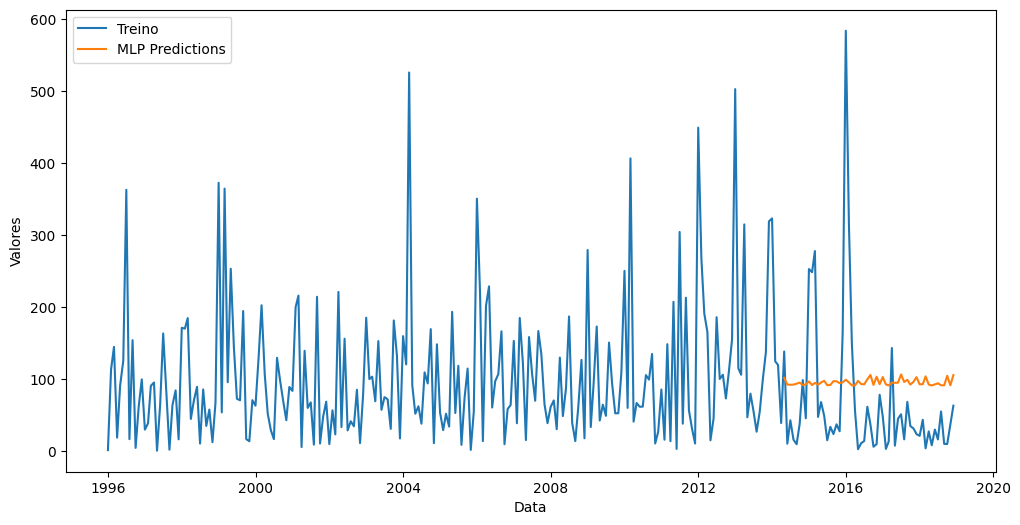

In [102]:
plot_forecasts_with_MLP(df_residuos_nordeste, y_pred_test_nord)

#### Guardando os resultados pra usar o LSTM

In [24]:
nordeste_train = prev_train[prev_train['unique_id'] == 'NORDESTE']
norte_train = prev_train[prev_train['unique_id'] == 'NORTE']

In [25]:
prev_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  24 non-null     object        
 1   ds         24 non-null     datetime64[ns]
 2   AutoARIMA  24 non-null     float32       
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 608.0+ bytes


In [26]:
teste_serie_regiao['y'] = teste_serie_regiao['y'].astype('float32')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16724\789762974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste_serie_regiao['y'] = teste_serie_regiao['y'].astype('float32')


In [27]:
prev_test['y'] = teste_serie_regiao['y']

In [28]:
teste_serie_regiao

,ds,y,unique_id
264,2018-01-01,494.0,NORDESTE
265,2018-02-01,405.0,NORDESTE
266,2018-03-01,461.0,NORDESTE
267,2018-04-01,435.0,NORDESTE
268,2018-05-01,432.0,NORDESTE
269,2018-06-01,452.0,NORDESTE
270,2018-07-01,428.0,NORDESTE
271,2018-08-01,492.0,NORDESTE
272,2018-09-01,387.0,NORDESTE
273,2018-10-01,415.0,NORDESTE
